In [98]:
import csv
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy.misc import imread, imsave
import cv2
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers import concatenate, Input
from keras.models import Model
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import pickle
import json

In [99]:
%matplotlib inline
sns.set_context("poster")

In [100]:
X_train = []
S_train = []
y_train = []

#drives = ['V79_run_office_1.pkl','V79_run_office_2.pkl']
drives = ['V79_run_run_1.pkl', 'V79_run_run_2.pkl', 'V79_run_run_3.pkl', 'V79_run_run_4.pkl']
for drive in drives:
    with open('{}'.format(drive), 'rb') as f:
        data = pickle.load(f,encoding='latin1')
            
    X_train.extend(data['images'])
    S_train.extend(data['sensors']) #RPM, throttle
    y_train.extend(data['steering_throttle'].astype(np.float64))
    
    #flip left to right
    X_train.extend(np.array([np.fliplr(x) for x in data['images']]))
    S_train.extend(data['sensors']) #RPM, throttle
    y_train.extend(np.negative(data['steering_throttle'].astype(np.float64)))
    
X_train = np.array(X_train)
S_train = np.array(S_train)
y_train = np.array(y_train)[:,[0]]

In [101]:
print(X_train.shape, S_train.shape, y_train.shape)

(52070, 80, 320, 3) (52070, 2) (52070, 1)


In [102]:
#we want to predict the steering angle for the next second of video. Here we 
#skip each 3 frames and predict on them
num_predict_ahead_frames_to_use = 90
predict_ahead_step_rate = 3
num_predict_ahead_frames = num_predict_ahead_frames_to_use//predict_ahead_step_rate

In [103]:
# go through and create a vectors for look ahead, let try though 10
steering_buffer = list(y_train[:num_predict_ahead_frames_to_use])
print(len(steering_buffer))
yy_train = []

for y in y_train[num_predict_ahead_frames_to_use:]:
    yy_train.append(steering_buffer[::predict_ahead_step_rate])
    steering_buffer.append(y)
    steering_buffer = steering_buffer[1:]

90


In [104]:
X_train = X_train[:-num_predict_ahead_frames_to_use]
S_train = S_train[:-num_predict_ahead_frames_to_use]
y_train = y_train[:-num_predict_ahead_frames_to_use]
yy_train = np.array(yy_train)

In [105]:
print(X_train.shape, S_train.shape, yy_train.shape)

(51980, 80, 320, 3) (51980, 2) (51980, 30, 1)


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


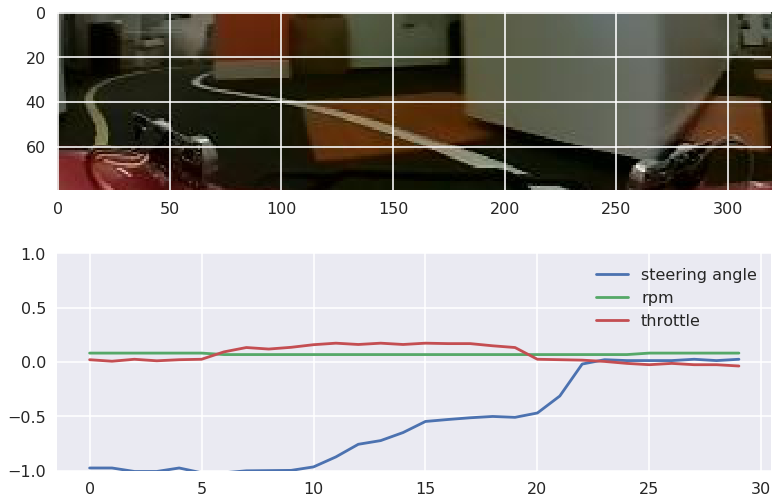

In [111]:
#view some images
frame = 220

plt.subplot(211)
plt.imshow(X_train[frame])
plt.subplot(212)
plt.plot(yy_train[frame], label="steering angle")
plt.plot(S_train[frame: frame + 90:3, 0], label="rpm")
plt.plot(S_train[frame: frame + 90:3, 1], label="throttle")
plt.ylim((-1,1))
plt.legend()
plt.show()


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


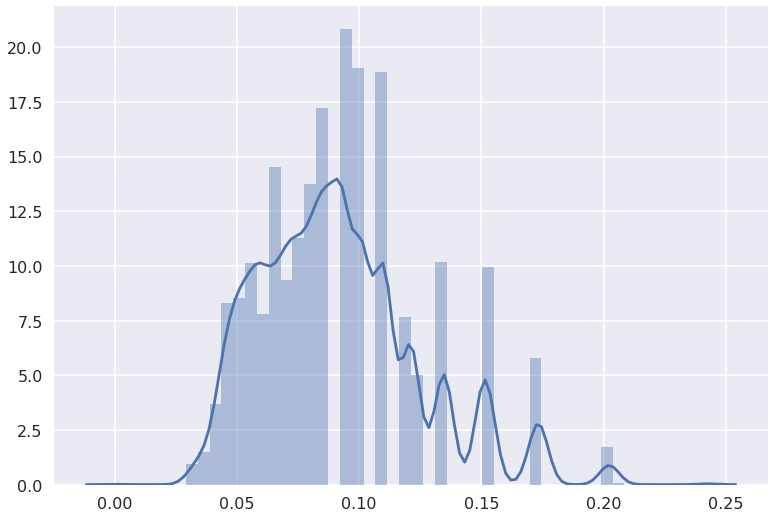

In [113]:
# lets look at the RPM data
sns.distplot(S_train[:,0])

In [114]:
def create_model():
    model = Sequential()
    
    #inputs
    image_input = Input(shape=(80, 320, 3), name='image_input', dtype='float32')
    sensor_input = Input(shape=(1,), name='sensor_input', dtype='float32')
    
    # preprocess
    X = Lambda(lambda x: x/255.0 - 0.5, input_shape=(80, 320, 3), name="lambda_1")(image_input)
    
    # conv1 layer
    X = Convolution2D(32, (5, 5), name="conv_1")(X)
    X = MaxPooling2D((2, 2), name="pool_1")(X)
    X = Activation('relu',name="relu_1")(X)
    
    # conv2 layer
    X = Convolution2D(64, (5, 5), name="conv_2")(X)
    X = MaxPooling2D((3, 3), name="pool_2")(X)
    X = Activation('relu', name="relu_2")(X)
    
    # conv3 layer
    X = Convolution2D(128, (3, 3), name="conv_3")(X)
    X = MaxPooling2D((2, 2), name="pool_3")(X)
    X = Activation('relu', name="relu_3")(X)

    # conv4 layer
    X = Convolution2D(128, (3, 3), name="conv_4")(X)
    X = MaxPooling2D((2, 2), name="pool_4")(X)
    X = Activation('relu', name="relu_4")(X)

    #add fully connected layers
    X = Flatten(name="flat_1")(X)
    
    #add in the speed, here we may add in other variables such 
    # as the last several throttle / speed/ steering angles, and other sensors
    X = concatenate([X, sensor_input], name="concate_1")
    
    # fc1
    X = Dense(1024, name="dnse_1")(X)
    X = Dropout(0.5, name="dropout_1")(X)
    X = Activation('relu', name="dense_relu_1")(X)
    
    # fc2
    X = Dense(128, name="dnse_2")(X)
    X = Dropout(0.5, name="dropout_2")(X)
    X = Activation('relu', name="dense_relu_2")(X)
    
    # fc2
    X = Dense(64, name="dnse_3")(X)
    X = Dropout(0.5, name="dropout_3")(X)
    X = Activation('relu', name="dense_relu_3")(X)
    
    #outputs are the next 10 frames
    steer_outputs = []
    for i in range(num_predict_ahead_frames):
        steer_output = Dense(1, name='steer_output_{}'.format(i))(X)
        steer_outputs.append(steer_output)
    
    

    #model = Model(inputs=[image_input, sensor_input], outputs=[steer_output, throttle_output])
    model = Model(inputs=[image_input, sensor_input], outputs=steer_outputs)

    loss_def = {"steer_output_{}".format(i) : "mse" for i in range(num_predict_ahead_frames)}
    loss_weight_def = {"steer_output_{}".format(i) : 1.0 for i in range(num_predict_ahead_frames)}
    
    # note, setting the loss weight to favor steering
    model.compile(optimizer='adam', loss=loss_def, loss_weights=loss_weight_def)

    return model

In [115]:
#create the model and save it as json
model = create_model()
with open("model.json", "w") as f:
    json.dump(model.to_json(), f)

In [116]:
#loading the model
from keras.models import model_from_json
with open("model.json") as f:
    model = model_from_json(json.load(f))
    model.compile(loss="mse", optimizer="adam")
#     model.load_weights("office_set_predict_ahead_90_2.h5")  #<--last run

In [117]:
y_output = {"steer_output_{}".format(i) : yy_train[:,i,:] for i in range(num_predict_ahead_frames)}

In [ ]:
hist = []
for i in range(0,30):
    print("{} --------------".format(i))
    h = model.fit({'image_input': X_train, 'sensor_input': S_train[:,0]},y_output, 
                  shuffle=True, epochs=5, validation_split=.3, batch_size=128)
    hist.append(h.history)
    with open('history.pkl', 'w') as f:
        json.dump(hist, f)
    model.save("office_set_predict_ahead_90_with_rpm_{}.h5".format(i))
    

0 --------------
Train on 36386 samples, validate on 15594 samples
Epoch 1/5
36386/36386 [==============================] - 122s - loss: 5.5621 - steer_output_0_loss: 0.1949 - steer_output_1_loss: 0.1860 - steer_output_2_loss: 0.1803 - steer_output_3_loss: 0.1819 - steer_output_4_loss: 0.1572 - steer_output_5_loss: 0.1726 - steer_output_6_loss: 0.1503 - steer_output_7_loss: 0.1750 - steer_output_8_loss: 0.1511 - steer_output_9_loss: 0.1438 - steer_output_10_loss: 0.1543 - steer_output_11_loss: 0.1595 - steer_output_12_loss: 0.1531 - steer_output_13_loss: 0.1501 - steer_output_14_loss: 0.1578 - steer_output_15_loss: 0.1539 - steer_output_16_loss: 0.1690 - steer_output_17_loss: 0.1716 - steer_output_18_loss: 0.1735 - steer_output_19_loss: 0.1764 - steer_output_20_loss: 0.1903 - steer_output_21_loss: 0.1983 - steer_output_22_loss: 0.1927 - steer_output_23_loss: 0.2058 - steer_output_24_loss: 0.2172 - steer_output_25_loss: 0.2269 - steer_output_26_loss: 0.2309 - steer_output_27_loss: 0.252

36386/36386 [==============================] - 119s - loss: 1.9067 - steer_output_0_loss: 0.0796 - steer_output_1_loss: 0.0701 - steer_output_2_loss: 0.0626 - steer_output_3_loss: 0.0571 - steer_output_4_loss: 0.0533 - steer_output_5_loss: 0.0515 - steer_output_6_loss: 0.0509 - steer_output_7_loss: 0.0515 - steer_output_8_loss: 0.0525 - steer_output_9_loss: 0.0542 - steer_output_10_loss: 0.0558 - steer_output_11_loss: 0.0573 - steer_output_12_loss: 0.0585 - steer_output_13_loss: 0.0595 - steer_output_14_loss: 0.0602 - steer_output_15_loss: 0.0607 - steer_output_16_loss: 0.0610 - steer_output_17_loss: 0.0608 - steer_output_18_loss: 0.0603 - steer_output_19_loss: 0.0598 - steer_output_20_loss: 0.0597 - steer_output_21_loss: 0.0598 - steer_output_22_loss: 0.0605 - steer_output_23_loss: 0.0621 - steer_output_24_loss: 0.0651 - steer_output_25_loss: 0.0696 - steer_output_26_loss: 0.0755 - steer_output_27_loss: 0.0830 - steer_output_28_loss: 0.0920 - steer_output_29_loss: 0.1023 - val_loss: 1

36386/36386 [==============================] - 119s - loss: 1.6985 - steer_output_0_loss: 0.0711 - steer_output_1_loss: 0.0621 - steer_output_2_loss: 0.0555 - steer_output_3_loss: 0.0509 - steer_output_4_loss: 0.0484 - steer_output_5_loss: 0.0474 - steer_output_6_loss: 0.0476 - steer_output_7_loss: 0.0484 - steer_output_8_loss: 0.0495 - steer_output_9_loss: 0.0505 - steer_output_10_loss: 0.0513 - steer_output_11_loss: 0.0517 - steer_output_12_loss: 0.0518 - steer_output_13_loss: 0.0519 - steer_output_14_loss: 0.0521 - steer_output_15_loss: 0.0523 - steer_output_16_loss: 0.0526 - steer_output_17_loss: 0.0531 - steer_output_18_loss: 0.0538 - steer_output_19_loss: 0.0544 - steer_output_20_loss: 0.0547 - steer_output_21_loss: 0.0551 - steer_output_22_loss: 0.0555 - steer_output_23_loss: 0.0563 - steer_output_24_loss: 0.0577 - steer_output_25_loss: 0.0606 - steer_output_26_loss: 0.0647 - steer_output_27_loss: 0.0706 - steer_output_28_loss: 0.0785 - steer_output_29_loss: 0.0881 - val_loss: 2

36386/36386 [==============================] - 119s - loss: 1.5073 - steer_output_0_loss: 0.0657 - steer_output_1_loss: 0.0568 - steer_output_2_loss: 0.0503 - steer_output_3_loss: 0.0464 - steer_output_4_loss: 0.0446 - steer_output_5_loss: 0.0443 - steer_output_6_loss: 0.0446 - steer_output_7_loss: 0.0451 - steer_output_8_loss: 0.0458 - steer_output_9_loss: 0.0462 - steer_output_10_loss: 0.0464 - steer_output_11_loss: 0.0463 - steer_output_12_loss: 0.0462 - steer_output_13_loss: 0.0460 - steer_output_14_loss: 0.0459 - steer_output_15_loss: 0.0461 - steer_output_16_loss: 0.0464 - steer_output_17_loss: 0.0470 - steer_output_18_loss: 0.0477 - steer_output_19_loss: 0.0483 - steer_output_20_loss: 0.0488 - steer_output_21_loss: 0.0491 - steer_output_22_loss: 0.0490 - steer_output_23_loss: 0.0490 - steer_output_24_loss: 0.0495 - steer_output_25_loss: 0.0509 - steer_output_26_loss: 0.0540 - steer_output_27_loss: 0.0591 - steer_output_28_loss: 0.0663 - steer_output_29_loss: 0.0757 - val_loss: 1

36386/36386 [==============================] - 119s - loss: 1.4921 - steer_output_0_loss: 0.0651 - steer_output_1_loss: 0.0564 - steer_output_2_loss: 0.0501 - steer_output_3_loss: 0.0463 - steer_output_4_loss: 0.0446 - steer_output_5_loss: 0.0443 - steer_output_6_loss: 0.0445 - steer_output_7_loss: 0.0452 - steer_output_8_loss: 0.0459 - steer_output_9_loss: 0.0462 - steer_output_10_loss: 0.0463 - steer_output_11_loss: 0.0459 - steer_output_12_loss: 0.0452 - steer_output_13_loss: 0.0448 - steer_output_14_loss: 0.0448 - steer_output_15_loss: 0.0450 - steer_output_16_loss: 0.0455 - steer_output_17_loss: 0.0461 - steer_output_18_loss: 0.0472 - steer_output_19_loss: 0.0480 - steer_output_20_loss: 0.0485 - steer_output_21_loss: 0.0487 - steer_output_22_loss: 0.0486 - steer_output_23_loss: 0.0486 - steer_output_24_loss: 0.0488 - steer_output_25_loss: 0.0501 - steer_output_26_loss: 0.0531 - steer_output_27_loss: 0.0581 - steer_output_28_loss: 0.0652 - steer_output_29_loss: 0.0750 - val_loss: 2

36386/36386 [==============================] - 119s - loss: 1.4607 - steer_output_0_loss: 0.0650 - steer_output_1_loss: 0.0561 - steer_output_2_loss: 0.0498 - steer_output_3_loss: 0.0458 - steer_output_4_loss: 0.0439 - steer_output_5_loss: 0.0434 - steer_output_6_loss: 0.0435 - steer_output_7_loss: 0.0440 - steer_output_8_loss: 0.0447 - steer_output_9_loss: 0.0449 - steer_output_10_loss: 0.0448 - steer_output_11_loss: 0.0445 - steer_output_12_loss: 0.0443 - steer_output_13_loss: 0.0441 - steer_output_14_loss: 0.0441 - steer_output_15_loss: 0.0442 - steer_output_16_loss: 0.0444 - steer_output_17_loss: 0.0451 - steer_output_18_loss: 0.0459 - steer_output_19_loss: 0.0465 - steer_output_20_loss: 0.0470 - steer_output_21_loss: 0.0473 - steer_output_22_loss: 0.0473 - steer_output_23_loss: 0.0476 - steer_output_24_loss: 0.0480 - steer_output_25_loss: 0.0492 - steer_output_26_loss: 0.0518 - steer_output_27_loss: 0.0564 - steer_output_28_loss: 0.0636 - steer_output_29_loss: 0.0735 - val_loss: 2

36386/36386 [==============================] - 119s - loss: 1.4549 - steer_output_0_loss: 0.0638 - steer_output_1_loss: 0.0550 - steer_output_2_loss: 0.0489 - steer_output_3_loss: 0.0451 - steer_output_4_loss: 0.0432 - steer_output_5_loss: 0.0430 - steer_output_6_loss: 0.0437 - steer_output_7_loss: 0.0445 - steer_output_8_loss: 0.0451 - steer_output_9_loss: 0.0453 - steer_output_10_loss: 0.0453 - steer_output_11_loss: 0.0449 - steer_output_12_loss: 0.0445 - steer_output_13_loss: 0.0441 - steer_output_14_loss: 0.0439 - steer_output_15_loss: 0.0441 - steer_output_16_loss: 0.0445 - steer_output_17_loss: 0.0452 - steer_output_18_loss: 0.0457 - steer_output_19_loss: 0.0465 - steer_output_20_loss: 0.0469 - steer_output_21_loss: 0.0471 - steer_output_22_loss: 0.0473 - steer_output_23_loss: 0.0473 - steer_output_24_loss: 0.0478 - steer_output_25_loss: 0.0489 - steer_output_26_loss: 0.0514 - steer_output_27_loss: 0.0561 - steer_output_28_loss: 0.0631 - steer_output_29_loss: 0.0728 - val_loss: 3

36386/36386 [==============================] - 119s - loss: 1.4436 - steer_output_0_loss: 0.0634 - steer_output_1_loss: 0.0545 - steer_output_2_loss: 0.0484 - steer_output_3_loss: 0.0446 - steer_output_4_loss: 0.0432 - steer_output_5_loss: 0.0432 - steer_output_6_loss: 0.0440 - steer_output_7_loss: 0.0447 - steer_output_8_loss: 0.0451 - steer_output_9_loss: 0.0450 - steer_output_10_loss: 0.0448 - steer_output_11_loss: 0.0446 - steer_output_12_loss: 0.0442 - steer_output_13_loss: 0.0438 - steer_output_14_loss: 0.0436 - steer_output_15_loss: 0.0438 - steer_output_16_loss: 0.0442 - steer_output_17_loss: 0.0448 - steer_output_18_loss: 0.0454 - steer_output_19_loss: 0.0460 - steer_output_20_loss: 0.0465 - steer_output_21_loss: 0.0467 - steer_output_22_loss: 0.0466 - steer_output_23_loss: 0.0465 - steer_output_24_loss: 0.0467 - steer_output_25_loss: 0.0478 - steer_output_26_loss: 0.0505 - steer_output_27_loss: 0.0553 - steer_output_28_loss: 0.0628 - steer_output_29_loss: 0.0727 - val_loss: 2

36386/36386 [==============================] - 119s - loss: 1.4369 - steer_output_0_loss: 0.0636 - steer_output_1_loss: 0.0547 - steer_output_2_loss: 0.0484 - steer_output_3_loss: 0.0447 - steer_output_4_loss: 0.0432 - steer_output_5_loss: 0.0431 - steer_output_6_loss: 0.0438 - steer_output_7_loss: 0.0445 - steer_output_8_loss: 0.0449 - steer_output_9_loss: 0.0449 - steer_output_10_loss: 0.0447 - steer_output_11_loss: 0.0444 - steer_output_12_loss: 0.0440 - steer_output_13_loss: 0.0436 - steer_output_14_loss: 0.0433 - steer_output_15_loss: 0.0435 - steer_output_16_loss: 0.0438 - steer_output_17_loss: 0.0443 - steer_output_18_loss: 0.0448 - steer_output_19_loss: 0.0456 - steer_output_20_loss: 0.0461 - steer_output_21_loss: 0.0463 - steer_output_22_loss: 0.0462 - steer_output_23_loss: 0.0463 - steer_output_24_loss: 0.0465 - steer_output_25_loss: 0.0476 - steer_output_26_loss: 0.0504 - steer_output_27_loss: 0.0551 - steer_output_28_loss: 0.0624 - steer_output_29_loss: 0.0723 - val_loss: 2

In [ ]:
predicted = model.predict({'image_input': X_train, 'sensor_input': S_train[:,0]})

In [ ]:
#visual actual vs predicted
plt.figure(figsize=(200,10))
plt.plot(y_train, label="train")
plt.plot(predicted, label="predicted")
plt.xticks()
plt.legend()
plt.xticks(np.arange(0,len(X_train), 100))
plt.show()

ValueError: x and y can be no greater than 2-D, but have shapes (30,) and (30, 51980, 1)

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


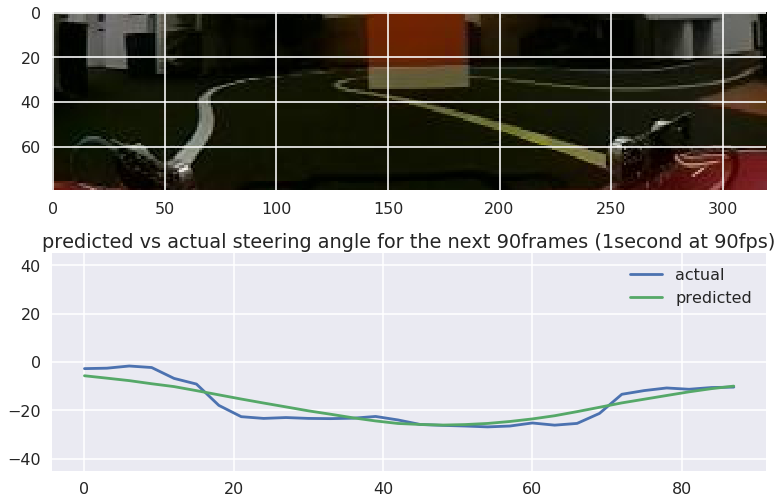

[[-0.06200002]
 [-0.05800001]
 [-0.03799998]
 [-0.052     ]
 [-0.152     ]
 [-0.20400001]
 [-0.4       ]
 [-0.50400001]
 [-0.52000003]
 [-0.51200002]
 [-0.52000003]
 [-0.52199995]
 [-0.51799995]
 [-0.50199992]
 [-0.53399997]
 [-0.57599996]
 [-0.58399997]
 [-0.59000007]
 [-0.59800008]
 [-0.59000007]
 [-0.56200002]
 [-0.58200005]
 [-0.56600003]
 [-0.47400004]
 [-0.298     ]
 [-0.26400002]
 [-0.23999998]
 [-0.252     ]
 [-0.23599998]
 [-0.23199997]]


In [126]:
#inference
frame = 2200

img = X_train[frame]
actual = yy_train[frame] * 45
predicted_angle = [x[frame][0] * 45 for x in predicted]



plt.subplot(211)
plt.imshow(X_train[frame])
plt.subplot(212)
plt.plot(np.arange(0,90,3),actual, label="actual")
plt.plot(np.arange(0,90,3),predicted_angle,  label="predicted")
plt.ylim((-45,45))
plt.legend()
plt.title("predicted vs actual steering angle for the next 90frames (1second at 90fps)")
plt.show()

print(yy_train[frame])